# Ingest Pancan + GTEX + TARGET

Download [Pancan/TCGA](https://www.cell.com/pb-assets/consortium/pancanceratlas/pancani3/index.html), [Pancan/TARGET](https://www.cancer.gov/ccg/research/genome-sequencing/target/about) and [GTEX](https://gtexportal.org) clinical labels and RNA-Seq genes expression computed by the [Toil recompute](https://xenabrowser.net/datapages/?hub=https://toil.xenahubs.net:443) from [Xena](https://xenabrowser.net), convert transcripts to [HUGO](https://www.genenames.org/) gene expression and clinical data.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Get current working directory
import sys
current_path = os.getcwd()
sys.path.append(os.path.join(current_path, '../..'))

In [3]:
from roug_ml.scripts.tcga_cancer_subtype import TCGASubtypePredictor

/Users/hector/DiaHecDev/data/pancan-gtex-target


In [8]:
import mlflow
from sklearn.pipeline import Pipeline

from collections import Counter
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from roug_ml.utl.etl.transforms_utl import integer_to_onehot

from roug_ml.utl.mlflow_utils import get_or_create_experiment
from roug_ml.models.hyperoptimization import get_best_run_from_hyperoptim
from roug_ml.utl.mlflow_utils import get_best_run
from roug_ml.models.pipelines.pipelines import NNTorch
from roug_ml.utl.evaluation.multiclass import compute_multiclass_confusion_matrix
from roug_ml.utl.evaluation.eval_utl import calc_loss_acc_val
from roug_ml.models.feature_selection import VarianceThresholdSelector, ModelBasedOneHotSelector, \
    AutoencoderFeatureSelector
from sklearn.svm import LinearSVC
from roug_ml.utl.data_vizualization.labels_vizualization import plot_label_distribution_from_arrays
from roug_ml.utl.dataset_split import stratified_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


import os
import numpy as np
import pandas as pd
from beartype.typing import Dict
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from projects.cancer_subtype_prediction.configs import TCGA_DATA_PATH
from roug_ml.utl.dowload_utils import download_file
from roug_ml.models.hyperoptimization import parallele_hyper_optim
from roug_ml.utl.parameter_utils import generate_param_grid_with_different_size_layers
from roug_ml.utl.parameter_utils import restructure_dict
print(TCGA_DATA_PATH)
import torch
from torch.utils.data import Dataset
from roug_ml.models.feature_selection import VarianceThresholdSelector, ModelBasedOneHotSelector, AutoencoderFeatureSelector
from sklearn.linear_model import LogisticRegression
from roug_ml.utl.etl.transforms_utl import one_hot_to_numeric, integer_to_onehot

/Users/hector/DiaHecDev/data/pancan-gtex-target


In [9]:
tcga = TCGASubtypePredictor(in_mlflow_experiment_name='TCGA_train_val_test5')

In [10]:
tcga_target_gtex_samples, tcga_gtex_labels, molecular_subtype, survival_labels_tcga = \
            tcga.collect_data()

tcga_gtex_labels
detailed_category
primary disease or tissue
_primary_site
_sample_type
_gender
_study
molecular_subtype
Subtype_mRNA
Subtype_DNAmeth
Subtype_protein
Subtype_miRNA
Subtype_CNA
Subtype_Integrative
Subtype_other
Subtype_Selected
survival_labels_tcga
_PATIENT
cancer type abbreviation
age_at_initial_pathologic_diagnosis
gender
race
ajcc_pathologic_tumor_stage
clinical_stage
histological_type
histological_grade
initial_pathologic_dx_year
menopause_status
birth_days_to
vital_status
tumor_status
last_contact_days_to
death_days_to
cause_of_death
new_tumor_event_type
new_tumor_event_site
new_tumor_event_site_other
new_tumor_event_dx_days_to
treatment_outcome_first_course
margin_status
residual_tumor
OS
OS.time
DSS
DSS.time
DFI
DFI.time
PFI
PFI.time
Redaction


In [7]:
from projects.cancer_subtype_prediction.etl import extract_gene_id_to_name_mapping

In [8]:
# Example usage:
gencode_release = "38"  # replace with desired release version
#genes = download_and_extract_protein_coding_genes(gencode_release, 'protein_coding_genes' + str(gencode_release) + '.csv')
#print(genes)
#print(f"Total number of protein-coding genes: {len(genes)}")
gencode_release = "38"  # replace with desired release version
# Extract the mapping
gtf_file_path = f"gencode.v{gencode_release}.annotation.gtf.gz"
gene_id_to_name_mapping = extract_gene_id_to_name_mapping(in_path_to_save_df='protein_coding_genes' + str(gencode_release) + '.csv', gencode_release=38)

In [9]:
gene_id_to_name_mapping

,Gene ID,Gene Name
0,ENSG00000186092.7,OR4F5
1,ENSG00000284733.2,OR4F29
2,ENSG00000284662.1,OR4F16
3,ENSG00000187634.13,SAMD11
4,ENSG00000188976.11,NOC2L
...,...,...
19950,ENSG00000212907.2,MT-ND4L
19951,ENSG00000198886.2,MT-ND4
19952,ENSG00000198786.2,MT-ND5
19953,ENSG00000198695.2,MT-ND6


In [10]:
gene_id_to_name_mapping['Gene ID'] = gene_id_to_name_mapping['Gene ID'].str.split('.').str[0]
gene_id_to_name_mapping

,Gene ID,Gene Name
0,ENSG00000186092,OR4F5
1,ENSG00000284733,OR4F29
2,ENSG00000284662,OR4F16
3,ENSG00000187634,SAMD11
4,ENSG00000188976,NOC2L
...,...,...
19950,ENSG00000212907,MT-ND4L
19951,ENSG00000198886,MT-ND4
19952,ENSG00000198786,MT-ND5
19953,ENSG00000198695,MT-ND6


In [11]:
columns_to_keep = set(gene_id_to_name_mapping['Gene ID'])
columns_to_keep

{'ENSG00000278619',
 'ENSG00000114520',
 'ENSG00000163704',
 'ENSG00000175931',
 'ENSG00000124587',
 'ENSG00000164399',
 'ENSG00000172009',
 'ENSG00000273045',
 'ENSG00000255393',
 'ENSG00000155659',
 'ENSG00000145087',
 'ENSG00000187021',
 'ENSG00000185761',
 'ENSG00000130300',
 'ENSG00000173894',
 'ENSG00000176595',
 'ENSG00000060140',
 'ENSG00000187678',
 'ENSG00000168418',
 'ENSG00000151929',
 'ENSG00000141179',
 'ENSG00000182040',
 'ENSG00000146399',
 'ENSG00000241837',
 'ENSG00000106633',
 'ENSG00000150773',
 'ENSG00000165417',
 'ENSG00000255374',
 'ENSG00000115267',
 'ENSG00000143486',
 'ENSG00000025423',
 'ENSG00000173653',
 'ENSG00000139329',
 'ENSG00000111752',
 'ENSG00000159339',
 'ENSG00000156738',
 'ENSG00000089486',
 'ENSG00000154620',
 'ENSG00000112208',
 'ENSG00000196290',
 'ENSG00000243749',
 'ENSG00000109472',
 'ENSG00000107036',
 'ENSG00000159377',
 'ENSG00000180881',
 'ENSG00000119965',
 'ENSG00000204576',
 'ENSG00000222011',
 'ENSG00000102312',
 'ENSG00000138709',


In [12]:
tcga_target_gtex_samples.columns = [col.split('.')[0] for col in tcga_target_gtex_samples.columns]
tcga_target_gtex_samples.columns

Index(['ENSG00000242268', 'ENSG00000259041', 'ENSG00000270112',
       'ENSG00000167578', 'ENSG00000278814', 'ENSG00000078237',
       'ENSG00000269416', 'ENSG00000263642', 'ENSG00000146083',
       'ENSG00000158486',
       ...
       'ENSG00000009694', 'ENSG00000238244', 'ENSG00000216352',
       'ENSG00000123685', 'ENSG00000267117', 'ENSG00000273233',
       'ENSG00000105063', 'ENSG00000231119', 'ENSG00000280861',
       'ENSG00000181518'],
      dtype='object', length=60498)

In [13]:
# Step 1: Check overlap
missing_columns = [col for col in columns_to_keep if col not in tcga_target_gtex_samples.columns]

print(f"Number of missing columns: {len(missing_columns)}")
print(missing_columns[:10])  # Print the first 10 missing columns for inspection

# Step 2: Update the list by removing the missing columns
columns_to_keep_updated = [col for col in columns_to_keep if col not in missing_columns]

# Step 3: Filter the dataframe
filtered_df = tcga_target_gtex_samples[columns_to_keep_updated]


Number of missing columns: 370
['ENSG00000286102', 'ENSG00000285585', 'ENSG00000283782', 'ENSG00000288636', 'ENSG00000286143', 'ENSG00000285000', 'ENSG00000284042', 'ENSG00000283288', 'ENSG00000286070', 'ENSG00000285777']


In [14]:
filtered_df

,ENSG00000278619,ENSG00000114520,ENSG00000163704,ENSG00000175931,ENSG00000124587,ENSG00000164399,ENSG00000172009,ENSG00000273045,ENSG00000255393,ENSG00000155659,...,ENSG00000006747,ENSG00000179431,ENSG00000182938,ENSG00000113272,ENSG00000167754,ENSG00000125618,ENSG00000116990,ENSG00000127588,ENSG00000112041,ENSG00000139567
GTEX-S4Q7-0003-SM-3NM8M,2.5561,6.2666,2.0218,4.2064,2.8858,-9.9658,6.2659,0.9568,-9.9658,-2.7274,...,3.8136,1.5758,-5.5735,3.7313,-3.8160,1.6740,0.7579,-5.0116,-9.9658,-3.4580
TCGA-19-1787-01,1.3956,4.4970,1.9302,3.5706,3.7667,-9.9658,5.4016,-0.4131,-9.9658,6.0202,...,4.5015,3.7193,-9.9658,3.1556,-9.9658,0.6332,2.4279,-5.0116,-5.5735,3.1556
TCGA-S9-A7J2-01,2.8260,4.1780,2.3677,4.7704,4.9336,-9.9658,6.7070,-0.4521,-9.9658,4.8120,...,2.3222,5.9255,-9.9658,2.7594,-9.9658,-2.3147,4.8048,-5.0116,-4.0350,2.5238
GTEX-QV31-1626-SM-2S1QC,1.9786,4.0260,0.1257,3.5706,2.4544,-9.9658,4.6006,-0.4521,-9.9658,4.1571,...,-0.4131,-0.6873,-9.9658,2.9802,-0.4521,1.0573,-2.9324,-9.9658,-1.9379,3.9496
TCGA-G3-A3CH-11,1.2696,4.1178,-3.4580,1.3567,2.4412,-9.9658,5.1918,-2.3884,-9.9658,3.4451,...,-6.5064,-0.4719,-9.9658,2.1378,-9.9658,-0.7834,3.2796,-9.9658,-9.9658,1.0573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-11ZTS-3326-SM-5LU9Y,1.2023,3.8411,3.3856,4.7877,4.6577,-9.9658,5.8555,2.0878,-9.9658,1.3051,...,-0.5125,0.7146,-9.9658,1.3511,-3.4580,1.0293,-0.0130,-3.8160,-3.0469,1.9490
GTEX-VJYA-0726-SM-4KL1T,2.2872,3.2973,1.1897,3.5694,3.3563,-9.9658,5.0018,-0.5125,-9.9658,0.6517,...,3.7930,2.4439,2.6464,3.0876,1.3511,0.3460,2.7336,-9.9658,-0.5125,1.8323
GTEX-ZA64-2126-SM-5Q5A8,2.4727,4.5129,0.6517,3.6172,4.1252,-9.9658,4.7819,-2.3147,-9.9658,3.6737,...,-0.2671,1.4174,-9.9658,2.6208,-9.9658,1.4756,0.2277,-9.9658,-2.4659,4.0109
GTEX-Q2AG-2826-SM-2HMJQ,1.0779,4.0445,4.0392,5.4970,5.1985,-9.9658,6.6796,1.9931,-9.9658,0.1648,...,-1.4305,3.1987,-9.9658,1.3340,-3.0469,0.8726,-0.3383,5.4657,-9.9658,1.6920


In [25]:
filtered_df.shape

(19131, 19567)

(array([2.8000e+01, 0.0000e+00, 2.0000e+00, 3.2000e+01, 1.3200e+02,
        6.0600e+02, 4.2710e+03, 1.0308e+04, 3.5080e+03, 2.4400e+02]),
 array([-9.9658, -8.1962, -6.4266, -4.657 , -2.8874, -1.1178,  0.6518,
         2.4214,  4.191 ,  5.9606,  7.7302]),
 <BarContainer object of 10 artists>)

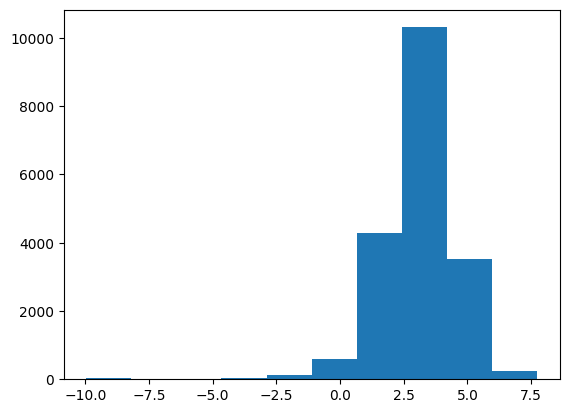

In [26]:
plt.hist(filtered_df.ENSG00000095002)

(array([6389., 1044., 5860., 3561., 1021.,  334.,  199.,  192.,  277.,
         254.]),
 array([-9.9658 , -7.94978, -5.93376, -3.91774, -1.90172,  0.1143 ,
         2.13032,  4.14634,  6.16236,  8.17838, 10.1944 ]),
 <BarContainer object of 10 artists>)

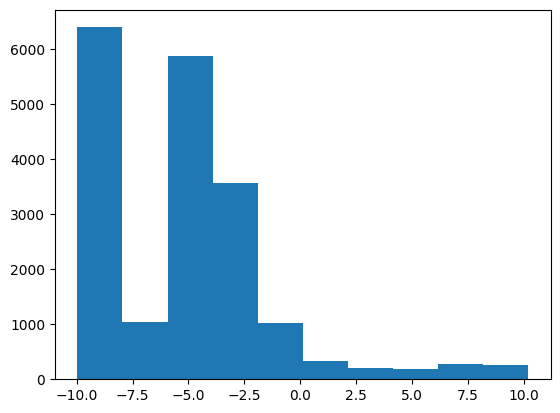

In [27]:
plt.hist(filtered_df.ENSG00000080618)

In [11]:
import requests
import os
import gseapy as gp

# 1. Download Reactome gene set

REACTOME_URL = "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/7.4/c2.cp.reactome.v7.4.symbols.gmt"
gmt_file_path = "./c2.cp.reactome.v7.4.symbols.gmt"

if not os.path.exists(gmt_file_path):
    response = requests.get(REACTOME_URL, stream=True)
    with open(gmt_file_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

# 2. Parse the gmt file to get the gene sets

def parse_gmt_file(gmt_path):
    with open(gmt_path, 'r') as f:
        lines = f.readlines()

    gene_sets = {}
    for line in lines:
        parts = line.strip().split("\t")
        gene_set_name = parts[0]
        genes = set(parts[2:])  # skipping the description
        gene_sets[gene_set_name] = genes

    return gene_sets

# Parse GMT file
gene_sets = parse_gmt_file(gmt_file_path)

# Collect all genes from the gene sets
all_genes = set()
for key in gene_sets:
    all_genes.update(gene_sets[key])

# Continue with the rest of the code as provided earlier...


In [12]:
all_genes

{'TCEA1',
 'LIPK',
 'RPL35A',
 'TAF1A',
 'ARHGAP32',
 'LILRA6',
 'DGAT2L6',
 'ESR2',
 'EPCAM',
 'PHYKPL',
 'IGKV3-20',
 'EFEMP2',
 'LIN9',
 'SQSTM1',
 'DNAJC3',
 'GOLIM4',
 'SLC22A4',
 'MYO9A',
 'NEK7',
 'C3AR1',
 'SIN3B',
 'SOCS6',
 'BTN3A3',
 'TRMT61A',
 'EHD1',
 'KIF12',
 'KCNH3',
 'ANK2',
 'CD300LD',
 'PANX1',
 'RRH',
 'TRMU',
 'LRRTM1',
 'PELI2',
 'MT1A',
 'LCK',
 'ZNF726',
 'PAIP1',
 'ELOVL1',
 'ZNF701',
 'RHOT2',
 'HECTD3',
 'RGS17',
 'CDC27',
 'WNT16',
 'DAGLB',
 'EEPD1',
 'OR2T1',
 'ACMSD',
 'AK8',
 'CHSY3',
 'TEN1',
 'MPO',
 'PIGN',
 'OR4A47',
 'NCSTN',
 'MRPL36',
 'SF3B5',
 'TXNRD2',
 'NTS',
 'NSMCE3',
 'KRT34',
 'POLE3',
 'BTNL8',
 'DDC',
 'IPPK',
 'MDH1',
 'PPP1R14A',
 'ZNF747',
 'DNMT1',
 'OR51B5',
 'FUT6',
 'ING4',
 'CETP',
 'GTPBP3',
 'ANAPC2',
 'RPSA',
 'RGS6',
 'ISL1',
 'SLC2A2',
 'ABHD5',
 'ARIH1',
 'CWC22',
 'RPA2',
 'TRIM39',
 'JAG1',
 'IL2',
 'F11R',
 'IER3',
 'EPHA8',
 'GUCY1A1',
 'RAP1GAP',
 'GFRA1',
 'AP2A2',
 'TNFSF11',
 'ING5',
 'OR8J1',
 'CTCF',
 'BHMT',
 'A

In [13]:
tcga_target_gtex_samples.shape

(19131, 60498)

In [16]:
from projects.cancer_subtype_prediction.etl import convert_and_save_mapping, extract_gene_id_to_name_mapping

In [19]:
# 1. Obtain the mapping from Ensembl gene IDs to gene names
gene_id_to_name_df = extract_gene_id_to_name_mapping(os.path.join(current_path, 'mapping_tcga_target_gtex_to_Ensembl_gene_bame.csv'), "38")  # Change the gencode_release if necessary


100% [........................................................................] 46556621 / 46556621

gunzip: gencode.v38.annotation.gtf already exists -- skipping


In [20]:
gene_id_to_name_df

,Gene ID,Gene Name
0,ENSG00000186092.7,OR4F5
1,ENSG00000284733.2,OR4F29
2,ENSG00000284662.1,OR4F16
3,ENSG00000187634.13,SAMD11
4,ENSG00000188976.11,NOC2L
...,...,...
19950,ENSG00000212907.2,MT-ND4L
19951,ENSG00000198886.2,MT-ND4
19952,ENSG00000198786.2,MT-ND5
19953,ENSG00000198695.2,MT-ND6


In [37]:
import os
import requests
import pandas as pd

import ftplib

def download_file_from_ftp(url: str, file_path: str) -> None:
    """
    Downloads a file from an FTP URL and saves it to the specified file path.
    """
    url_parts = url.split("/")
    server = url_parts[2]
    file_dir = "/".join(url_parts[3:-1])
    filename = url_parts[-1]
    
    with ftplib.FTP(server) as ftp:
        ftp.login()
        ftp.cwd(file_dir)
        
        with open(file_path, 'wb') as f:
            ftp.retrbinary(f"RETR {filename}", f.write)

def extract_gene_id_to_name_mapping(in_path_to_save_df: str, gencode_release: str) -> pd.DataFrame:
    """
    Downloads the GTF file for a specified GENCODE release version and extracts a
    mapping from Ensembl gene IDs to gene names.

    :param in_path_to_save_df: Path to save the dataframe containing the gene ID to name mapping.
    :param gencode_release: GENCODE release version, e.g., "v38".
    :return: DataFrame mapping Ensembl gene IDs to gene names.
    """
    if os.path.exists(in_path_to_save_df):
        df = pd.read_csv(in_path_to_save_df)
    else:
        base_url = f"ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_{gencode_release}/gencode.v{gencode_release}.annotation.gtf.gz"
        
        # Specify a directory for storing the GTF files (modify as necessary)
        gtf_dir = "gtf_files"
        os.makedirs(gtf_dir, exist_ok=True)
        
        destination = os.path.join(gtf_dir, f"gencode.v{gencode_release}.annotation.gtf.gz")

        # Download the file
        print(f"Downloading GENCODE {gencode_release} GTF file...")
        download_file_from_ftp(base_url, destination)
        # Unzipping the file
        os.system(f"gunzip {destination}")

        gtf_file_path = destination.replace(".gz", "")
        gene_id_to_name = {}
        with open(gtf_file_path, 'r') as file:
            for line in file:
                if line.startswith('#'):
                    continue
                fields = line.strip().split('\t')
                if fields[2] == "gene":
                    info = {x.split()[0]: x.split()[1].replace('"', '').replace(';', '') for x in
                            fields[8].split('; ')}
                    # Remove the condition to check if gene_type is protein_coding.
                    gene_id_to_name[info['gene_id']] = info['gene_name']

        df = pd.DataFrame(list(gene_id_to_name.items()), columns=['Gene ID', 'Gene Name'])
        df.to_csv(in_path_to_save_df, index=False)

    return df



In [38]:
gene_id_to_name_df = extract_gene_id_to_name_mapping(
    os.path.join(TCGA_DATA_PATH, 'all_gene_maping_Ensembl_gene_name.csv'), 
    "38")  # Change the gencode_release if necessary


In [39]:
gene_id_to_name_df

,Gene ID,Gene Name
0,ENSG00000223972.5,DDX11L1
1,ENSG00000227232.5,WASH7P
2,ENSG00000278267.1,MIR6859-1
3,ENSG00000243485.5,MIR1302-2HG
4,ENSG00000284332.1,MIR1302-2
...,...,...
60644,ENSG00000198695.2,MT-ND6
60645,ENSG00000210194.1,MT-TE
60646,ENSG00000198727.2,MT-CYB
60647,ENSG00000210195.2,MT-TT


In [45]:
gene_id_to_name_df['Gene ID'] = gene_id_to_name_df['Gene ID'].str.split('.').str[
            0]

In [46]:
gene_id_to_name_map = dict(zip(gene_id_to_name_df['Gene ID'], gene_id_to_name_df['Gene Name']))

gene_id_to_name_map

{'ENSG00000223972': 'DDX11L1',
 'ENSG00000227232': 'WASH7P',
 'ENSG00000278267': 'MIR6859-1',
 'ENSG00000243485': 'MIR1302-2HG',
 'ENSG00000284332': 'MIR1302-2',
 'ENSG00000237613': 'FAM138A',
 'ENSG00000268020': 'OR4G4P',
 'ENSG00000240361': 'OR4G11P',
 'ENSG00000186092': 'OR4F5',
 'ENSG00000238009': 'RP11-34P13.7',
 'ENSG00000239945': 'RP11-34P13.8',
 'ENSG00000233750': 'CICP27',
 'ENSG00000268903': 'RP11-34P13.15',
 'ENSG00000269981': 'RP11-34P13.16',
 'ENSG00000239906': 'RP11-34P13.14',
 'ENSG00000241860': 'RP11-34P13.13',
 'ENSG00000222623': 'RNU6-1100P',
 'ENSG00000241599': 'RP11-34P13.9',
 'ENSG00000279928': 'DDX11L17',
 'ENSG00000279457': 'WASH9P',
 'ENSG00000273874': 'MIR6859-2',
 'ENSG00000228463': 'AP006222.1',
 'ENSG00000286448': 'AP006222.3',
 'ENSG00000236679': 'RPL23AP24',
 'ENSG00000236601': 'RP4-669L17.2',
 'ENSG00000237094': 'RP4-669L17.4',
 'ENSG00000269732': 'WBP1LP7',
 'ENSG00000284733': 'OR4F29',
 'ENSG00000233653': 'CICP7',
 'ENSG00000250575': 'RP4-669L17.8',
 'E

In [47]:
# 2. Update the dataframe columns using this mapping
tcga_target_gtex_samples.columns = [gene_id_to_name_map.get(col.split('.')[0], col) for col in tcga_target_gtex_samples.columns]


In [48]:
tcga_target_gtex_samples

,LINC02082,RP11-167B3.1,ST8SIA5-DT,RAB4B,ENSG00000278814.1,TIGAR,LINC01224,MIR4802,RNF44,DNAH3,...,TENM1,GABARAPL3,RP11-486E2.1,BATF3,AC010525.4,RP11-713D19.1,PPP6R1,RP4-569M23.2,ENSG00000280861.1,OR8D4
GTEX-S4Q7-0003-SM-3NM8M,-3.4580,-9.9658,-3.6259,4.5988,-9.9658,2.2633,-6.5064,-9.9658,5.7811,-4.2934,...,-3.3076,-9.9658,-9.9658,3.4804,-2.3884,-3.3076,5.8102,-3.8160,-9.9658,-9.9658
TCGA-19-1787-01,-9.9658,-9.9658,-3.8160,5.2998,-9.9658,3.5086,0.8647,-9.9658,4.2465,-5.0116,...,-1.4305,-9.9658,-9.9658,1.2271,-3.3076,-1.2481,5.2661,-0.2159,-9.9658,-9.9658
TCGA-S9-A7J2-01,0.2998,-9.9658,-3.0469,4.8881,-9.9658,2.3019,-1.0262,-9.9658,5.3806,-9.9658,...,1.5661,-2.9324,-9.9658,1.1577,-9.9658,-1.2142,4.8151,-3.3076,-9.9658,-9.9658
GTEX-QV31-1626-SM-2S1QC,-9.9658,-9.9658,-2.1779,4.6294,-9.9658,1.9931,-9.9658,-9.9658,3.8279,-9.9658,...,0.4657,-0.9132,-9.9658,2.1925,-9.9658,-9.9658,4.9905,-9.9658,-9.9658,-9.9658
TCGA-G3-A3CH-11,-9.9658,-9.9658,-9.9658,3.5572,-9.9658,0.0990,-9.9658,-9.9658,1.8323,-9.9658,...,-1.7809,-9.9658,-9.9658,0.2642,-3.6259,-9.9658,3.4358,-2.5479,-9.9658,-9.9658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-11ZTS-3326-SM-5LU9Y,1.5165,-9.9658,-2.9324,6.0809,-9.9658,1.9749,-5.5735,-9.9658,4.9416,-1.1811,...,2.7615,-9.9658,-9.9658,1.1577,-9.9658,-9.9658,5.2758,-0.9132,-9.9658,-9.9658
GTEX-VJYA-0726-SM-4KL1T,-9.9658,-9.9658,-9.9658,4.7410,-9.9658,2.4465,-0.6416,-9.9658,4.9284,-1.5105,...,-4.0350,-9.9658,-9.9658,-0.1187,-1.3921,-9.9658,5.0505,-5.0116,-9.9658,-9.9658
GTEX-ZA64-2126-SM-5Q5A8,-2.3884,-9.9658,-9.9658,5.3212,-9.9658,1.4228,-9.9658,-9.9658,4.6764,-1.6394,...,0.3115,-9.9658,-9.9658,1.2147,-9.9658,-9.9658,4.5021,-0.6416,-9.9658,-4.6082
GTEX-Q2AG-2826-SM-2HMJQ,0.0440,-9.9658,2.5852,5.8110,-9.9658,0.7748,0.3115,-9.9658,5.8415,-5.5735,...,4.3111,-9.9658,-9.9658,-0.6643,-1.9379,-0.8863,5.2843,-2.5479,-9.9658,-9.9658


In [49]:
tcga_target_gtex_samples.columns

Index(['LINC02082', 'RP11-167B3.1', 'ST8SIA5-DT', 'RAB4B', 'ENSG00000278814.1',
       'TIGAR', 'LINC01224', 'MIR4802', 'RNF44', 'DNAH3',
       ...
       'TENM1', 'GABARAPL3', 'RP11-486E2.1', 'BATF3', 'AC010525.4',
       'RP11-713D19.1', 'PPP6R1', 'RP4-569M23.2', 'ENSG00000280861.1',
       'OR8D4'],
      dtype='object', length=60498)

In [51]:
import gseapy as gp
from gseapy.plot import barplot, dotplot

# Assuming `important_genes` is a list of important genes from SHAP analysis
enr = gp.enrichr(gene_list=['LINC02082', 'RP11-167B3.1', 'ST8SIA5-DT', 'RAB4B'],
                 gene_sets='KEGG_2019_Human',
                 outdir='test/enrichr_kegg',
                 cutoff=0.5 # This is the p-value cutoff for significant pathways
                 )

# To visualize the results
barplot(enr.res2d, title='KEGG', ofname='KEGG_enrichment_results')


ValueError: Warning: No enrich terms when cutoff = 0.5

In [ ]:
# 2. Update the dataframe columns using this mapping
your_dataframe.columns = [gene_id_to_name_map.get(col, col) for col in your_dataframe.columns]


In [ ]:
filtered_df = tcga_target_gtex_samples.loc[:, tcga_target_gtex_samples.columns.isin(all_genes)]


In [ ]:
in_tcga_target_gtex_samples.columns = [col.split('.')[0] for col in
                                    in_tcga_target_gtex_samples.columns]



In [14]:
filtered_df = tcga_target_gtex_samples[tcga_target_gtex_samples['Gene ID'].isin(all_genes)]


KeyError: 'Gene ID'

In [15]:
from projects.cancer_subtype_prediction.etl import convert_and_save_mapping

In [16]:
mapping_df = convert_and_save_mapping(ensembl_gene_id_list=tcga_target_gtex_samples.columns[0:10], in_path=os.path.join(current_path, 'mapping_tcga_target_gtex_to_Ensembl_Protein_ID.csv'))
print('end')

ENSG00000242268.2
ENSG00000259041.1
ENSG00000270112.3
ENSG00000167578.16
Ensembl Gene ID: ENSG00000167578.16 -> Ensembl Protein ID: ENSP00000470246
ENSG00000278814.1
ENSG00000078237.5
Ensembl Gene ID: ENSG00000078237.5 -> Ensembl Protein ID: ENSP00000488928
ENSG00000269416.5
ENSG00000263642.1
ENSG00000146083.11
Ensembl Gene ID: ENSG00000146083.11 -> Ensembl Protein ID: ENSP00000274811
ENSG00000158486.13
Ensembl Gene ID: ENSG00000158486.13 -> Ensembl Protein ID: ENSP00000513632
end


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Switch to a scratch data directory so all paths are local
os.makedirs(os.path.expanduser("/Users/marion/Documents/ADLIN/Projet_IntegratiOMICS/Données/pancan-gtex-target"), exist_ok=True)
os.chdir(os.path.expanduser("/Users/marion/Documents/ADLIN/Projet_IntegratiOMICS/Données/pancan-gtex-target"))

PermissionError: [Errno 13] Permission denied: '/Users/marion'

In [ ]:
#pip install tensorflow

## Ingest Samples

In [ ]:
# Download raw files from xena
# https://xenabrowser.net/datapages/?dataset=TcgaTargetGtex_rsem_gene_tpm&host=https%3A%2F%2Ftoil.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443
!wget -q -N https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/TcgaTargetGtex_rsem_gene_tpm.gz

In [ ]:
%%time
# Convert to float32, Transpose to ML style rows = samples and hdf for significantly faster reading
if not os.path.exists(os.path.expanduser("TcgaTargetGtex_rsem_gene_tpm.T.fp32.h5")):
   pd.read_table(os.path.expanduser("TcgaTargetGtex_rsem_gene_tpm.gz"), index_col=0, engine='c') \
        .astype(np.float32).T \
        .to_hdf(os.path.expanduser("TcgaTargetGtex_rsem_gene_tpm.T.fp32.h5"), "expression", mode="w", format="fixed")

In [ ]:
%%time
tcga_target_gtex_samples = pd.read_hdf(os.path.expanduser("TcgaTargetGtex_rsem_gene_tpm.T.fp32.h5"))

In [ ]:
#Gene expression log2(tpm+0.001)
tcga_target_gtex_samples.head()

In [ ]:
index_values = tcga_target_gtex_samples.index.str.contains('GTEX|TCGA|TARGET')

In [ ]:
# Count the number of rows with 'gtex', 'tcga', and 'target' in the index column
gtex_count = index_values[tcga_target_gtex_samples.index.str.contains('GTEX')].sum()
tcga_count = index_values[tcga_target_gtex_samples.index.str.contains('TCGA')].sum()
target_count = index_values[tcga_target_gtex_samples.index.str.contains('TARGET')].sum()

In [ ]:
# Histo
labels = ['gtex', 'tcga', 'target']
values = [gtex_count, tcga_count, target_count]

plt.bar(labels, values)
plt.xlabel('Cohortes')
plt.ylabel('Nombre échantillons')
plt.title

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')
    
plt.show()

### Duplicats patients/Echantillons

In [ ]:
duplicate_rows = tcga_target_gtex_samples.duplicated()
duplicate_data = tcga_target_gtex_samples[duplicate_rows]

In [ ]:
duplicate_data

Il n'y a pas d'échantillon dupliqué.

## Ingest Labels

In [ ]:
# !wget -q -N https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/TcgaTargetGTEX_phenotype.txt.gz

In [ ]:
tcga_gtex_labels = pd.read_table(
    "TcgaTargetGTEX_phenotype.txt.gz", compression="gzip", 
    header=0, sep="\t", encoding="ISO-8859-1", index_col=0, dtype="str").sort_index(axis="index")

In [ ]:
tcga_gtex_labels

In [ ]:
num_rows, num_cols = tcga_gtex_labels.shape
print("Nombre de lignes :", num_rows)
print("Nombre de colonnes :", num_cols)

### Explore sample types

In [ ]:
#Print occurences of each sample type
value_counts = tcga_gtex_labels['_sample_type'].value_counts()
print(value_counts)

In [ ]:
# Obtenir les différentes valeurs de '_sample_type' avec leur décompte
unique_value_counts = value_counts.index

# Parcourir les valeurs uniques de '_sample_type' et afficher les valeurs correspondantes de '_study'
for value in unique_value_counts:
    matching_values_study = tcga_gtex_labels.loc[tcga_gtex_labels['_sample_type'] == value, '_study']
    print("Valeurs correspondantes de _study pour", value, " (Count:", value_counts[value], "):", matching_values_study.tolist())

#### Sample type by studies

#### Solid tissue normal vs primary tumor 

In [ ]:
# Filter Solid Tissue Normal samples from TCGA
Solid_Tissue_Normal_samples = tcga_gtex_labels[tcga_gtex_labels.index.str.startswith('TCGA') & tcga_gtex_labels.index.str.endswith('11')]
Solid_Tissue_Normal_samples

Il y a 727 échantillons de Solid Tissue Normal

In [ ]:
# Filter two corresponding samples
index_values = ['TCGA-YB-A89D-01', 'TCGA-YB-A89D-11']
Corresponding_samples = tcga_gtex_labels.loc[index_values]
Corresponding_samples

In [ ]:
#Filtrer les échantillons avec des paires d'échantillon
TCGA_12_samples = tcga_gtex_labels[tcga_gtex_labels.index.str[:12].duplicated(keep=False) & tcga_gtex_labels.index.str.startswith('TCGA')]
TCGA_12_samples

On voit qu'il y a des échantillons qui se terminent par 01 : Primary Tumor, 02 : Recurrent Tumor et par 11 : Solid Tissue Normal

In [ ]:
#On enlève toutes les valeurs 02
TCGA_12_samples_moins02 = TCGA_12_samples[~TCGA_12_samples.index.str.endswith('02')]
TCGA_12_samples_moins02

In [ ]:
# Créer une colonne avec les 12 premiers caractères 
TCGA_12_samples_moins02['12_premiers'] = TCGA_12_samples_moins02.index.str[:12]

# Filtrer les échantillons par paire avec les mêmes 12 premiers caractères
filtered_samples_paire_normal_tumor = TCGA_12_samples_moins02[TCGA_12_samples_moins02.duplicated('12_premiers', keep=False)]
filtered_samples_paire_normal_tumor

Il y a 1438/2 = 719 patients avec à la fois Solid Tissue Normal et Primary Tumor

## PCA

In [ ]:
tcga_gtex_labels_GTEX_TCGA = tcga_gtex_labels[tcga_gtex_labels['_study'].isin(['GTEX', 'TCGA'])]
tcga_gtex_labels_GTEX_TCGA

In [ ]:
tcga_gtex_labels

In [ ]:
tcga_target_gtex_samples

In [ ]:
# First, you may want to merge the two data frames into one
# This assumes that you have a common column (like 'id') to merge on
combined_df = tcga_target_gtex_samples.merge(tcga_gtex_labels, left_index=True, right_index=True, how='inner')

In [ ]:
combined_df

In [ ]:
combined_df['combined_primary_site_study'] = combined_df.apply(lambda row: f"{row['_primary_site']}-{row['_study']}", axis=1)
combined_df

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# Convert  primary_site into numerical values for one-hot multi-class training
from sklearn.preprocessing import LabelEncoder

tumor_normal_encoder = LabelEncoder()
combined_df["sample_type_value"] = pd.Series(
    tumor_normal_encoder.fit_transform(combined_df["_sample_type"]), index=combined_df.index)

primary_site_encoder = LabelEncoder()
combined_df["primary_site_value"] = pd.Series(
    primary_site_encoder.fit_transform(combined_df["combined_primary_site_study"]), index=combined_df.index)

disease_encoder = LabelEncoder()
combined_df["disease_value"] = pd.Series(
    disease_encoder.fit_transform(combined_df["primary disease or tissue"]), index=combined_df.index)

combined_df.describe(include="all", percentiles=[])

In [ ]:
combined_df

### Identifier le nombre d'échantillons communs entre GTEX et TCGA

In [ ]:
df_new = combined_df[['combined_primary_site_study', 'primary_site_value']].rename(columns={
    'combined_primary_site_study': 'target_names',
    'primary_site_value': 'target'
})
df_new

In [ ]:
pd.set_option('display.max_rows', None)
summary = df_new['target_names'].value_counts().sort_index()
print(summary)

In [ ]:
X = tcga_target_gtex_samples.values
y = df_new['target'].values

In [ ]:
unique_values = df_new.groupby('target_names')['target'].unique()
unique_values

In [ ]:
target_names = {
    0:'Adipose Tissue-GTEX',
    1:'Adrenal Gland-GTEX', 
    2:'Adrenal gland-TCGA',
    3:'Bile duct-TCGA',
    4:'Bladder-GTEX',
    5:'Blood-GTEX',
    6:'Blood Vessel-GTEX',
    7:'Bone Marrow-GTEX',
    8:'Brain-GTEX/TCGA',
    9:'Breast',
    10:'Cervix',
    11:'Cervix Uteri',
    12:'Colon',
    13:'Endometrium',
    14:'Esophagus',
    15:'Eye',
    16:'Fallopian Tube',
    17:'Head and Neck region',
    18:'Heart',
    19:'Kidney',
    20:'Lining of body cavities',
    21:'Liver',
    22:'Lung',
    23:'Lymphatic tissue',
    24:'Muscle',
    25:'Nerve',
    26:'Ovary',
    27:'Pancreas',
    28:'Paraganglia',
    29:'Pituitary',
    30:'Prostate',
    31:'Rectum',
    32:'Salivary Gland',
    33:'Skin',
    34:'Small Intestine',
    35:'Soft tissue,Bone',
    36:'Spleen',
    37:'Stomach',
    38:'SympatheticÊNervous System',
    39:'Testis',
    40:'Thymus',
    41:'Thyroid',
    42:'Thyroid Gland',
    43:'Uterus',
    44:'Vagina',
    45:'White blood cell'
}


In [ ]:
# Convertir les valeurs uniques de numpy array à list
unique_values_list = unique_values.apply(list)

# Convertir la série en un dictionnaire
unique_values_dict = unique_values_list.to_dict()

print(unique_values_dict)

In [ ]:
# Standardizing the features because PCA is effected by scale
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
# Perform PCA
pca = PCA(n_components=3) # number of components to keep, change as per your need
principalComponents = pca.fit_transform(X_scaled)

print('Shape before PCA: ', X_scaled.shape)
print('Shape after PCA: ', principalComponents.shape)
 
pca_df = pd.DataFrame(
    data=principalComponents, 
    columns=['PC1', 'PC2', 'PC3'])

In [ ]:
y

In [ ]:
pca_df['target'] = y
pca_df['target'] = pca_df['target'].map(target_names)
 
pca_df

In [ ]:
import plotly.express as px

# Créez votre graphique
fig = px.scatter(pca_df, x='PC1', y='PC2', color='target')

# Affichez le graphique
fig.show()

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
 
sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df, 
    hue='target', 
    fit_reg=False, 
    legend=True
    )
 
plt.title('2D PCA Graph')
plt.gcf().set_size_inches(20, 20)
plt.show()



In [ ]:
# Créer une figure
plt.figure(figsize=(10, 8))

# Utiliser les étiquettes cibles pour colorer les points
for i, target in enumerate(target_names.keys()):
    plt.scatter(principalComponents[y == target, 0], principalComponents[y == target, 1], label=target_names[target])

plt.legend()  # Afficher la légende
plt.xlabel('Premier Composant Principal')
plt.ylabel('Deuxième Composant Principal')
plt.title('PCA avec des noms de cibles')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1])
plt.xlabel('Premier Composant Principal')
plt.ylabel('Deuxième Composant Principal')
plt.title('PCA sur les données')
plt.show()

In [ ]:
# Create a DataFrame with the principal components
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'], index=combined_df.index)

In [ ]:
# If you have a target in the original dataframes, you can add it to this dataframe
finalDf = pd.concat([principalDf, combined_df[['_primary_site_value']]], axis=1) # replace 'target' with your actual target column

## Wrangle labels

Convert tumor/normal, primary site and disease into one hot outputs and combine into a single multi-class multi-label output vectoro to train against.

In [ ]:
pca = PCA(n_components=2)  # Définir le nombre de composantes principales souhaitées
pca_result = pca.fit_transform(expression_data_scaled)

In [ ]:
df_clinical = tcga_gtex_labels
df_clinical

In [ ]:
# Ajoutez les informations cliniques au DataFrame de résultats de PCA
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['_study'] = df_clinical['_study']  # Colonne contenant les informations cliniques à utiliser pour la couleur

# Affichez le graphique PCA en utilisant les informations cliniques pour la couleur
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['_study'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - TCGA Data')
plt.colorbar(label='_study')
plt.show()

In [ ]:
# Convert  primary_site into numerical values for one-hot multi-class training
from sklearn.preprocessing import LabelEncoder

tumor_normal_encoder = LabelEncoder()
tcga_gtex_labels["sample_type_value"] = pd.Series(
    tumor_normal_encoder.fit_transform(tcga_gtex_labels["_sample_type"]), index=tcga_gtex_labels.index)

primary_site_encoder = LabelEncoder()
tcga_gtex_labels["primary_site_value"] = pd.Series(
    primary_site_encoder.fit_transform(tcga_gtex_labels["_primary_site"]), index=tcga_gtex_labels.index)

disease_encoder = LabelEncoder()
tcga_gtex_labels["disease_value"] = pd.Series(
    disease_encoder.fit_transform(tcga_gtex_labels["primary disease or tissue"]), index=tcga_gtex_labels.index)

tcga_gtex_labels.describe(include="all", percentiles=[])

In [ ]:
tcga_gtex_labels

In [ ]:
# Create a multi-class one hot output all four classifications
from keras.utils import np_utils
Y_onehot = np.append(
    tcga_gtex_labels["sample_type_value"].values.reshape(tcga_gtex_labels.shape[0],-1), 
    np_utils.to_categorical(tcga_gtex_labels["primary_site_value"]), axis=1)
Y_onehot = np.append(Y_onehot,
    np_utils.to_categorical(tcga_gtex_labels["disease_value"]), axis=1)
print(Y_onehot.shape)

In [ ]:
# Check out one-hot compound output vector
for i in range(0,20000,5000):
    y = Y.iloc[i]
    print("{} {} {}".format(y.tumor_normal, y.primary_site, y.disease))
    
    yo = Y_onehot[i]
    print(tumor_normal_encoder.classes_.tolist()[int(yo[0])],
          primary_site_encoder.classes_.tolist()[np.argmax(yo[1:1+46])],
          disease_encoder.classes_.tolist()[np.argmax(yo[1+46:-1])])

## Stratify Split into Train/Test

Split the data into training and test sets stratified by primary side. Check that we get a good distribution of both primary site and disease between each of these sets.

In [ ]:
# Split into stratified training and test sets based primary site
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X_pruned.values, Y["primary_site_value"]):
    X_train = X_pruned.values[train_index]
    X_test = X_pruned.values[test_index]
    y_train = Y_onehot[train_index]
    y_test = Y_onehot[test_index]
    primary_site_train = Y["primary_site_value"].values[train_index]
    primary_site_test = Y["primary_site_value"].values[test_index]
    disease_train = Y["disease_value"].values[train_index]
    disease_test = Y["disease_value"].values[test_index]

print(X_train.shape, X_test.shape)

In [ ]:
# Lets see how big each class is based on primary site
plt.hist(primary_site_train, alpha=0.5, label='Train')
plt.hist(primary_site_test, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Primary Site distribution between train and test")
plt.show()

# Lets see how big each class is based on primary site
plt.hist(disease_train, alpha=0.5, label='Train')
plt.hist(disease_test, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Disease distribution between train and test")
plt.show()

## Multi-label Classification

In [ ]:
Label gender, primary site, tumor/normal and disease all at once

In [ ]:
%%time
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

classify = [
    InputLayer(input_shape=(X_train.shape[1],)),
    BatchNormalization(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(128, activity_regularizer=regularizers.l1(1e-5), activation='relu'),
    Dropout(0.5),

    # Sigmoid as we have multiple labels
    Dense(y_train.shape[1], activation='sigmoid')
]

model = Sequential(classify)
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max")]
model.fit(X_train, y_train, epochs=10, batch_size=128, shuffle="batch", callbacks=callbacks)
print(model.metrics_names, model.evaluate(X_test, y_test))

In [ ]:
# Save the model for separate inference
with open("models/multi_label.params.json", "w") as f:
    f.write(json.dumps({
        "tumor_normal": tumor_normal_encoder.classes_.tolist(),
        "primary_site": primary_site_encoder.classes_.tolist(),
        "disease": disease_encoder.classes_.tolist(),
        "genes": all_gene_set_genes}))

with open("models/multi_label.model.json", "w") as f:
    f.write(model.to_json())

model.save_weights("models/multi_label.weights.h5")

In [ ]:
# Load the model and predict the test set
model = keras.models.model_from_json(open("models/multi_label.model.json").read())
model.load_weights("models/multi_label.weights.h5")
params = json.loads(open("models/multi_label.params.json").read())
predictions = model.predict(X_test)

In [ ]:
# Plot the distribution of tumor/normal values
plt.hist(predictions[:,0])
plt.show()

In [ ]:
# Plot the confusion matrix disease
from sklearn.metrics import confusion_matrix
print("Tumor/Normal")
print(confusion_matrix(y_test[:,0], np.round(predictions[:,0])))

print("Primary Site")
plt.matshow(confusion_matrix(primary_site_test, 
                                     np.array([np.argmax(p) for p in predictions[:,1:1+46]])), 
            cmap='jet')
plt.title("Primary Site Prediction Confusion Matrix")
plt.show()

plt.matshow(confusion_matrix(disease_test, 
                             np.array([np.argmax(p) for p in predictions[:,1+46:-1]])), 
            cmap='jet')
plt.title("Disease Prediction Confusion Matrix")
plt.show()

In [ ]:
# Let's eye ball a few predictions compared to the original
for i in range(0,20000,2000):
    print("Original: {} {} {}".format(Y.iloc[i].tumor_normal, Y.iloc[i].primary_site, Y.iloc[i].disease))
    
    prediction = model.predict(X_pruned.iloc[i:i+1])[0]  
    print("Predicted:",
          tumor_normal_encoder.classes_.tolist()[int(round(prediction[0]))],
          primary_site_encoder.classes_.tolist()[np.argmax(prediction[1:1+46])],
          disease_encoder.classes_.tolist()[np.argmax(prediction[1+46:-1])])

### Explorer les sample_types et si dans GTEX on a que des tissus sains + t-SNE + Vérifier si le patient a sain et cancer

## Ingest molecular subtype

In [ ]:
!wget -q -N https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/TCGASubtype.20170308.tsv.gz

In [ ]:
molecular_subtype = pd.read_table(
    "TCGASubtype.20170308.tsv.gz", compression="gzip", 
    header=0, sep="\t", encoding="ISO-8859-1", index_col=0, dtype="str").sort_index(axis="index")



In [ ]:
molecular_subtype

In [ ]:
molecular_subtype['Subtype_mRNA'] = molecular_subtype['Subtype_mRNA'].fillna('')
filtered_molecular_subtype = molecular_subtype[molecular_subtype['Subtype_mRNA'].str.contains('LumA')]
print(filtered_molecular_subtype)

### Vérifier les même temps de survie que le dataframe R

## Ingest survival labels

### TCGA

In [ ]:
!wget -q -N https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/Survival_SupplementalTable_S1_20171025_xena_sp

In [ ]:
survival_labels = pd.read_table(
    "Survival_SupplementalTable_S1_20171025_xena_sp", 
    header=0, sep="\t", encoding="ISO-8859-1", index_col=0, dtype="str").sort_index(axis="index")

In [ ]:
survival_labels

In [ ]:
num_rows, num_cols = survival_labels.shape
print("Nombre de lignes :", num_rows)
print("Nombre de colonnes :", num_cols)

### TARGET

In [ ]:
!wget -q -N https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/TARGET_donor_allprojects_transfer_to_sample.gz

In [ ]:
survival_labels_target = pd.read_table(
    "TARGET_donor_allprojects_transfer_to_sample.gz", compression="gzip",
    header=0, sep="\t", encoding="ISO-8859-1", index_col=0, dtype="str").sort_index(axis="index")

In [ ]:
survival_labels_target

### Merge TCGA survival labels and expression data

In [ ]:
all_labels = pd.merge(tcga_gtex_labels, survival_labels, left_index=True, right_index=True, how="outer").astype('str')
print("Ingested {} labels for {} samples".format(all_labels.shape[1], all_labels.shape[0]))
all_labels.iloc[::all_labels.shape[0]//5]

In [ ]:
num_rows, num_cols = all_labels.shape
print("Nombre de lignes :", num_rows)
print("Nombre de colonnes :", num_cols)

In [ ]:
all_labels

In [ ]:
duplicate_rows = all_labels.duplicated()
duplicate_data = all_labels[duplicate_rows]

In [ ]:
duplicate_data

In [ ]:
all_labels_no_duplicates = all_labels.drop_duplicates()

In [ ]:
all_labels_no_duplicates